In [1]:
from typing import Tuple
import itertools
from pathlib import Path
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from monai.networks import nets, one_hot
from monai.metrics import compute_hausdorff_distance

import plotly.express as px
from plotly.colors import n_colors
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

pio.templates.default = "simple_white"

import seaborn as sns

import skimage as skm
from scipy import interpolate

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision import transforms

import torchio as tio

from kedro.extras.datasets.pandas import CSVDataSet
from kedro.extras.datasets.pickle import PickleDataSet

In [2]:
import os, sys
sys.path.append(os.path.abspath('../src'))

from tagseg.data import ScdEvaluator, MnmEvaluator
from tagseg.data.dmd_dataset import DmdH5DataSet, DmdH5Evaluator
from tagseg.models.trainer import Trainer
from tagseg.models.segmenter import Net
from tagseg.metrics.dice import DiceMetric
from tagseg.pipelines.model_evaluation.nodes import tag_subjects
from tagseg.data.dmd_dataset import DmdDataSet

In [3]:
top_h_legend = dict(orientation='h', yanchor="bottom", y=1.1)

In [4]:
index = pd.read_csv('../data/07_model_output/index.csv')
index

,architecture,strategy,model
0,nnUnet,Scratch,model_dmd_v2
1,nnUnet,Physics-driven,model_cine_v8_simtag_v1_dmd_v1
2,nnUnet,CycleGAN,model_cine_v8_tag_v1_dmd_v2
3,nnUnet,Cine,model_cine_v8_dmd_v0
4,ResNetVAE,Scratch,model_dmd_v6
5,ResNetVAE,Cine,model_cine_v4_dmd_v0
6,ResNetVAE,Physics-driven,model_cine_v6_simtag_v1_dmd_v1
7,ResNetVAE,CycleGAN,model_cine_v6_tag_v1_dmd_v2


In [5]:
pf = PickleDataSet(filepath=f'../data/07_model_output/E150/dmd_results.pt').load()
pf = pd.DataFrame(list(pf))

In [6]:
pf[pf.dice_lv > 0.].dice_lv.mean()

0.8611052508761243

In [7]:
dfs = [] 

for _, row in index.iterrows():

    for split in ['train', 'test']:

        ext = '_train' if split == 'train' else ''

        df = PickleDataSet(filepath=f'../data/07_model_output/{row.model}/dmd_results{ext}.pt').load()
        df = pd.DataFrame(list(df))

        assert 'voxel_spacing' in df.columns

        df['architecture'] = row.architecture
        df['strategy'] = row.strategy
        df['split'] = split

        dfs.append(df)

In [8]:
df = pd.concat(dfs)
len(df)

10000

In [13]:
results = df.pivot_table(index=['architecture', 'strategy'], values=['dice', 'hd95'], columns=['split'], aggfunc=['median', 'mean', 'std']) \
    .sort_index(level=[1, 2], ascending=[True, False], axis=1).reorder_levels([1, 2, 0], axis=1) \
    .sort_index(level=[0, 1], ascending=[False, False]) \

results

dice                                          \
split                           train                          test             
                               median      mean       std    median      mean   
architecture strategy                                                           
nnUnet       Scratch         0.896250  0.894026  0.020609  0.790744  0.770596   
             Physics-driven  0.897467  0.895478  0.019799  0.788367  0.785013   
             CycleGAN        0.895981  0.893940  0.019824  0.794329  0.779121   
             Cine            0.897571  0.894672  0.019905  0.774368  0.769969   
ResNetVAE    Scratch         0.874556  0.872231  0.027364  0.810722  0.800767   
             Physics-driven  0.897545  0.894917  0.023166  0.817342  0.811073   
             CycleGAN        0.900188  0.898459  0.021707  0.836251  0.827879   
             Cine            0.851797  0.819623  0.099790  0.844418  0.818192   

                                           hd95                                \
split                                     train                          test   
                                  std    median      mean       std    median   
architecture strategy                                                           
nnUnet       Scratch         0.083577  2.857143  2.518677  0.553900  5.714286   
             Physics-driven  0.053936  2.865574  3.114616  0.870777  5.686111   
             CycleGAN        0.073641  2.020305  2.385461  0.569049  5.714286   
             Cine            0.078095  2.020305  2.325431  0.544957  5.745062   
ResNetVAE    Scratch         0.064837  3.194383  3.301001  0.746071  5.150788   
             Physics-driven  0.067673  2.857143  2.517113  0.563500  4.517540   
             CycleGAN        0.049004  2.313198  2.480807  0.572409  4.285714   
             Cine            0.096033  4.058993  6.620694  8.740514  4.285714   

                                                 
split                                            
                                 mean       std  
architecture strategy                            
nnUnet       Scratch         7.219269  5.074511  
             Physics-driven  5.845877  1.625485  
             CycleGAN        6.117169  2.087476  
             Cine            6.700094  3.434931  
ResNetVAE    Scratch         5.615966  1.989304  
             Physics-driven  5.406894  3.349835  
             CycleGAN        4.745034  1.536825  
             Cine            5.647481  5.548856

In [14]:
print(results.to_latex(
    float_format="%.3f", bold_rows=True, column_format='llrrrrrrrr', multicolumn_format='c', multirow=True,
    caption='Something retarded'
))

\begin{table}
\centering
\caption{Something retarded}
\begin{tabular}{llrrrrrrrr}
\toprule
          & {} & \multicolumn{6}{c}{dice} & \multicolumn{6}{c}{hd95} \\
          & \textbf{split} & \multicolumn{3}{c}{train} & \multicolumn{3}{c}{test} & \multicolumn{3}{c}{train} & \multicolumn{3}{c}{test} \\
          & {} & median &  mean &   std & median &  mean &   std & median &  mean &   std & median &  mean &   std \\
\textbf{architecture} & \textbf{strategy} &        &       &       &        &       &       &        &       &       &        &       &       \\
\midrule
\multirow{4}{*}{\textbf{nnUnet}} & \textbf{Scratch} &  0.896 & 0.894 & 0.021 &  0.791 & 0.771 & 0.084 &  2.857 & 2.519 & 0.554 &  5.714 & 7.219 & 5.075 \\
          & \textbf{Physics-driven} &  0.897 & 0.895 & 0.020 &  0.788 & 0.785 & 0.054 &  2.866 & 3.115 & 0.871 &  5.686 & 5.846 & 1.625 \\
          & \textbf{CycleGAN} &  0.896 & 0.894 & 0.020 &  0.794 & 0.779 & 0.074 &  2.020 & 2.385 & 0.569 &  5.714 & 6.117 & 2.087 \

/tmp/ipykernel_24254/318273618.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results.to_latex(


In [15]:
df = df[df.split == 'test'].reset_index()

In [10]:
df.patient_id = df.patient_id.astype(str)
df.head()

,image,raw_mask,pred,dice,hd95,timeframe,voxel_spacing,raw_shape,group,subgroup,disease,location,patient_id,slice,architecture,strategy,split
0,"{'data': [[tensor([[-2.0357, -2.0357, -2.0357,...","{'data': [[tensor([[0., 0., 0., ..., 0., 0., ...","{'data': [[tensor([[0, 0, 0, ..., 0, 0, 0], ...",0.628022,10.161541,0,1.428571,"(180, 224)",1,0,control,UCLA,008,base,nnUnet,Scratch,test
1,"{'data': [[tensor([[-2.0357, -2.0357, -2.0357,...","{'data': [[tensor([[0., 0., 0., ..., 0., 0., ...","{'data': [[tensor([[0, 0, 0, ..., 0, 0, 0], ...",0.678809,8.143398,1,1.428571,"(180, 224)",1,0,control,UCLA,008,base,nnUnet,Scratch,test
2,"{'data': [[tensor([[-2.0357, -2.0357, -2.0357,...","{'data': [[tensor([[0., 0., 0., ..., 0., 0., ...","{'data': [[tensor([[0, 0, 0, ..., 0, 0, 0], ...",0.706670,9.147321,2,1.428571,"(180, 224)",1,0,control,UCLA,008,base,nnUnet,Scratch,test
3,"{'data': [[tensor([[-2.0357, -2.0357, -2.0357,...","{'data': [[tensor([[0., 0., 0., ..., 0., 0., ...","{'data': [[tensor([[0, 0, 0, ..., 0, 0, 0], ...",0.718475,10.615941,3,1.428571,"(180, 224)",1,0,control,UCLA,008,base,nnUnet,Scratch,test
4,"{'data': [[tensor([[-2.0357, -2.0357, -2.0357,...","{'data': [[tensor([[0., 0., 0., ..., 0., 0., ...","{'data': [[tensor([[0, 0, 0, ..., 0, 0, 0], ...",0.770085,7.142857,4,1.428571,"(180, 224)",1,0,control,UCLA,008,base,nnUnet,Scratch,test


In [16]:
sorter = ['Scratch', 'Cine', 'Physics-driven', 'CycleGAN']
df.strategy = df.strategy.astype('category')
df.strategy = df.strategy.cat.set_categories(sorter)
df.sort_values('strategy', inplace=True)

In [22]:
fig = make_subplots(rows=2, cols=2, shared_yaxes=True, shared_xaxes=True, horizontal_spacing=0.02, vertical_spacing=0.10)

for m, metric in enumerate(['dice', 'hd95']):
    for i, (a, s, d) in enumerate(itertools.product(df.architecture.unique(), df.strategy.unique(), df.disease.unique())):

        fdf = df[(df.architecture == a) & (df.strategy == s) & (df.disease == d)]
        
        fig.add_trace(
            go.Violin(
                x=fdf.strategy, y=fdf[metric],
                legendgroup=d, scalegroup=d, name=d.upper(), side='negative' if d == 'control' else 'positive',
                line_color='#197278' if d == 'control' else '#C44536', showlegend=True if i in [0, 1] and m == 1 else False,
            ), row=m + 1, col=1 if a == 'nnUnet' else 2
        )
        
        if m == 1:
            fig.update_xaxes(title_text=a, row=2, col=1 if a == 'nnUnet' else 2)

fig.update_yaxes(title_text='DSC (↑)', range=[0, 1], dtick=0.1, row=1, col=1)
fig.update_yaxes(range=[0, 1], row=1, col=2)
fig.update_yaxes(title_text='HD-95 [mm] (↓)', range=[0, 25], row=2, col=1)
fig.update_yaxes(range=[0, 25], row=2, col=2)
fig.update_traces(meanline_visible=True, width=.9, points=False)
fig.update_layout(violingap=0, violinmode='overlay', legend=top_h_legend)
fig.update_layout(height=800 / 1.62, width=800)
fig.show()

In [23]:
fig.write_image("../../figures/disease-perf-violin.pdf")

In [14]:
df.melt(id_vars=['patient_id', 'architecture', 'strategy'], value_vars=['dice', 'hd95']).head()

,patient_id,architecture,strategy,variable,value
0,008,nnUnet,Scratch,dice,0.628022
1,015,ResNetVAE,Scratch,dice,0.843541
2,015,ResNetVAE,Scratch,dice,0.853302
3,015,ResNetVAE,Scratch,dice,0.847607
4,015,ResNetVAE,Scratch,dice,0.846213


In [19]:
colors = ['#219EBC', '#FB8500', '#023047', '#C44536']

fig = px.strip(
    df.melt(id_vars=['patient_id', 'architecture', 'strategy'], value_vars=['dice', 'hd95']), 
    x='patient_id', y='value', color='strategy', facet_col='architecture', facet_row='variable',
    labels=dict(patient_id='Patient ID', variable='Performance metric', strategy='Training strategy', architecture='Model architecture'),
    color_discrete_sequence=colors
)
fig.update_yaxes(matches=None)
fig.update_layout(legend=top_h_legend)

fig.update_yaxes(title_text='HD-95 [mm] (↓)', range=[0, 25], row=1, col=1)
fig.update_yaxes(range=[0, 25], row=1, col=2)
for a, s in itertools.product(df.architecture.unique(), df.strategy.unique()):
    avg = df[(df.architecture == a) & (df.strategy == s)].hd95.mean()
    fig.add_hline(
        y=avg, line_width=3, line_dash="dot", line_color=colors[list(df.strategy.unique()).index(s)], row=1, col=int(a == 'nnUnet')
    )

fig.update_yaxes(title_text='DSC (↑)', range=[0, 1], row=2, col=1)
fig.update_yaxes(range=[0, 1], row=2, col=2)
for a, s in itertools.product(df.architecture.unique(), df.strategy.unique()):
    avg = df[(df.architecture == a) & (df.strategy == s)].dice.mean()
    fig.add_hline(
        y=avg, line_width=3, line_dash="dot", line_color=colors[list(df.strategy.unique()).index(s)], row=2, col=int(a == 'nnUnet')
    )

fig.update_layout(height=800 / 1.62, width=800)
fig.show()

/opt/conda/envs/tagseg/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [20]:
fig.write_image("../../figures/patient-performance-strip.pdf")

In [21]:
colors = n_colors('rgb(25, 114, 120)', 'rgb(196, 69, 54)', 25, colortype='rgb')

fig = make_subplots(rows=2, cols=4, shared_yaxes=True, shared_xaxes=True, horizontal_spacing=0.02, vertical_spacing=0.02)

for i, architecture in enumerate(df.architecture.unique()):

    fig.update_yaxes(title_text=f'{architecture}<br>Timeframe', row=i + 1, col=1)

    for j, strategy in enumerate(df.strategy.unique()):

        fig.update_xaxes(title_text=f'DSC (↑)<br>{strategy}', row=2, col=j + 1)

        data = np.array(list(map(lambda t: np.array(df[(df.timeframe == t) & (df.architecture == architecture) & (df.strategy == strategy)].dice), range(25))))

        for t, (data_line, color) in enumerate(zip(data, colors)):
            fig.add_trace(go.Violin(name=t + 1, x=data_line, line_color=color), row=i + 1, col=j + 1)
            fig.update_xaxes(range=[0.1, 1.2], tickvals=np.arange(0.2, 1.1, 0.1,), row=i + 1, col=j + 1)
            fig.update_yaxes(range=[-1, 28], tickvals=np.arange(0, 30, 5), ticktext=np.arange(0, 30, 5), row=i + 1, col=j + 1)
        
        fig.add_vline(
            x=data.mean(),
            annotation_text=f"     {data.mean():.3f}", annotation_position="top right", 
            annotation_font_color='rgb(40, 61, 59)',
            line_width=3, line_dash="dot", line_color='rgb(40, 61, 59)', row=i + 1, col=j + 1)

fig.update_traces(orientation='h', side='positive', width=3, points=False)
fig.update_layout(height=800 / 1.62, width=800, showlegend=False)
fig.show()

In [18]:
fig.write_image("../../figures/model-performance-violin.pdf")

/opt/conda/envs/tagseg/lib/python3.8/site-packages/matplotlib/backends/backend_pdf.py:1721: DeprecationWarning:

NONE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.

/opt/conda/envs/tagseg/lib/python3.8/site-packages/matplotlib/backends/backend_pdf.py:1722: DeprecationWarning:

ADAPTIVE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Palette.ADAPTIVE instead.



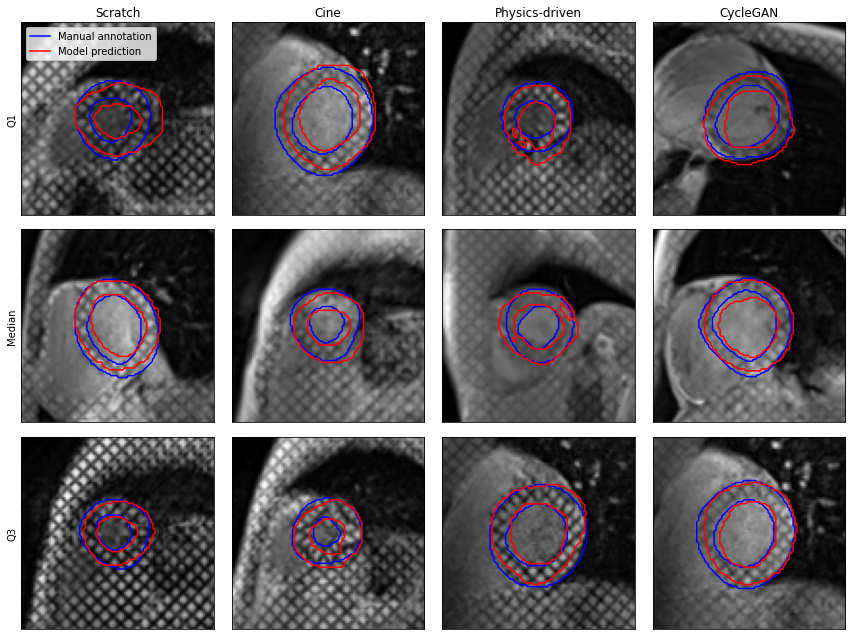

In [19]:
fig, ax = plt.subplots(3, len(df.strategy.unique()), figsize=(12, 9))

padding = 50

for m, strategy in enumerate(df.strategy.unique()):

    subs = df[(df.architecture == 'nnUnet') & (df.strategy == strategy)].copy()

    for i, (title, quantile) in enumerate(zip(['Q1', 'Median', 'Q3'], subs.dice.quantile([.25, .5, .75]))):

        subs['diff'] = (subs.dice - quantile).abs()

        subject = subs.sort_values('diff', ascending=True).iloc[0]

        post_process = transforms.Resize(subject.raw_shape)

        image = post_process(subject.image.data)[0, 0].numpy()
        mask = subject['raw_mask'].data[0, 0].numpy()
        pred = subject.pred.data[0, 0].numpy()

        center = [list(map(lambda a: a.mean(), np.where(mask == 1))), list(map(lambda a: a.mean(), np.where(pred == 1)))]

        ax[i, m].imshow(image, cmap='gray')

        # Label only once
        for j, contour in enumerate(skm.measure.find_contours(mask, level=.5)):
            ax[i, m].plot(*contour[:, ::-1].T, c='b', label='Manual annotation' if j == 0 else None)
        for j, contour in enumerate(skm.measure.find_contours(pred, level=.5)):
            ax[i, m].plot(*contour[:, ::-1].T, c='r', label='Model prediction' if j == 0 else None)

        ax[i, m].get_xaxis().set_ticks([])
        ax[i, m].get_yaxis().set_ticks([])

        center_y, center_x = np.array(center).mean(axis=0)
        ax[i, m].set_xlim(center_x - padding, center_x + padding)
        ax[i, m].set_ylim(center_y + padding, center_y - padding)
        
        ax[i, 0].set_ylabel(title)

    ax[0, m].set_title(strategy)

ax[0, 0].legend(loc='upper left')

plt.tight_layout()
plt.savefig('../../figures/qualitative-nnUnet.pdf', bbox_inches='tight')
plt.show()

/opt/conda/envs/tagseg/lib/python3.8/site-packages/matplotlib/backends/backend_pdf.py:1721: DeprecationWarning:

NONE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.

/opt/conda/envs/tagseg/lib/python3.8/site-packages/matplotlib/backends/backend_pdf.py:1722: DeprecationWarning:

ADAPTIVE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Palette.ADAPTIVE instead.



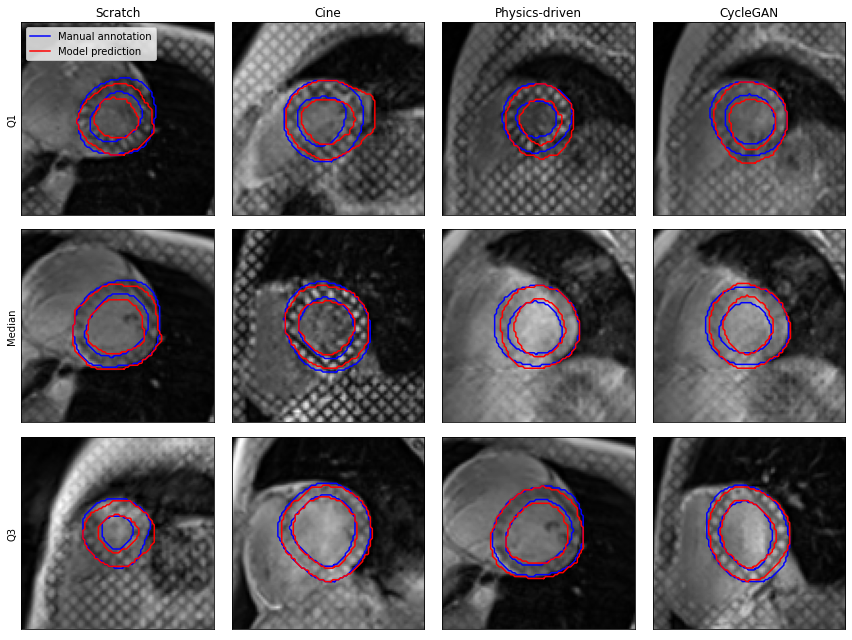

In [20]:
fig, ax = plt.subplots(3, len(df.strategy.unique()), figsize=(12, 9))

padding = 50

for m, strategy in enumerate(df.strategy.unique()):

    subs = df[(df.architecture == 'ResNetVAE') & (df.strategy == strategy)].copy()

    for i, (title, quantile) in enumerate(zip(['Q1', 'Median', 'Q3'], subs.dice.quantile([.25, .5, .75]))):

        subs['diff'] = (subs.dice - quantile).abs()

        subject = subs.sort_values('diff', ascending=True).iloc[0]

        post_process = transforms.Resize(subject.raw_shape)

        image = post_process(subject.image.data)[0, 0].numpy()
        mask = subject['raw_mask'].data[0, 0].numpy()
        pred = subject.pred.data[0, 0].numpy()

        center = [list(map(lambda a: a.mean(), np.where(mask == 1))), list(map(lambda a: a.mean(), np.where(pred == 1)))]

        ax[i, m].imshow(image, cmap='gray')

        # Label only once
        for j, contour in enumerate(skm.measure.find_contours(mask, level=.5)):
            ax[i, m].plot(*contour[:, ::-1].T, c='b', label='Manual annotation' if j == 0 else None)
        for j, contour in enumerate(skm.measure.find_contours(pred, level=.5)):
            ax[i, m].plot(*contour[:, ::-1].T, c='r', label='Model prediction' if j == 0 else None)

        ax[i, m].get_xaxis().set_ticks([])
        ax[i, m].get_yaxis().set_ticks([])

        center_y, center_x = np.array(center).mean(axis=0)
        ax[i, m].set_xlim(center_x - padding, center_x + padding)
        ax[i, m].set_ylim(center_y + padding, center_y - padding)
        
        ax[i, 0].set_ylabel(title)

    ax[0, m].set_title(strategy)

ax[0, 0].legend(loc='upper left')

plt.tight_layout()
plt.savefig('../../figures/qualitative-ResNetVAE.pdf', bbox_inches='tight')
plt.show()